In [1]:
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPool2D, Conv2DTranspose, UpSampling2D, Reshape
from tensorflow.keras.models import Sequential, Model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
output_path = 'video.avi'
fps = 10
image_counter=0
losses = []

In [3]:
encoder_input_layer = Input([480, 640,3])

encoder_layers = Conv2D(8, (3,3), activation="relu", padding="same")(encoder_input_layer)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(16, (3,3), activation="relu", padding="same")(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(32, (3,3), activation="relu", padding="same")(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(32, (3,3), activation="relu", padding="same")(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Flatten()(encoder_layers)

encoder_layers = Dense(32)(encoder_layers)

# decoder_input_layer = Input([32])

decoder_layers = Dense(38400, input_shape=[32])(encoder_layers)

decoder_layers = Reshape([30, 40, 32])(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(32, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(32, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(16, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(8, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = Conv2D(3, (3,3), activation="sigmoid", padding="same")(decoder_layers)

# Models 
autoencoder_model = Model(encoder_input_layer, decoder_layers)
encoder_model = Model(encoder_input_layer, encoder_layers)
decoder_model = Sequential(autoencoder_model.layers[11:])

# Compile model
autoencoder_model.compile(optimizer="adam", loss="mse")

In [4]:

from __future__ import print_function
import vizdoom as vzd

from random import choice
from time import sleep

vizdoom_path = "../../../../Mech Punk/Anaconda3/envs/vizdoom/lib/vizdoom/scenarios/"

if __name__ == "__main__":
    # Create DoomGame instance. It will run the game and communicate with you.
    game = vzd.DoomGame()

    # Now it's time for configuration!
    # load_config could be used to load configuration instead of doing it here with code.
    # If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
    # game.load_config("../../scenarios/basic.cfg")

    # Sets path to additional resources wad file which is basically your scenario wad.
    # If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
    game.set_doom_scenario_path(vizdoom_path + "basic.wad")
    # Sets map to start (scenario .wad files can contain many maps).
    game.set_doom_map("map01")

    # Sets resolution. Default is 320X240
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

    # Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
    game.set_screen_format(vzd.ScreenFormat.RGB24)

    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)

    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)

    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)

    # Enables information about all objects present in the current episode/level.
    game.set_objects_info_enabled(True)

    # Enables information about all sectors (map layout).
    game.set_sectors_info_enabled(True)

    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)  # Smoke and blood
    game.set_render_messages(False)  # In-game messages
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

    # Adds buttons that will be allowed.
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)

    # Adds game variables that will be included in state.
    game.add_available_game_variable(vzd.GameVariable.AMMO2)

    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(300)

    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(10)

    # Makes the window appear (turned on by default)
    game.set_window_visible(False)

    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(False)

    # Sets the livin reward (for each move) to -1
    game.set_living_reward(-1)

    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(vzd.Mode.PLAYER)

    # Enables engine output to console.
    #game.set_console_enabled(True)

    # Initialize the game. Further configuration won't take any effect from now on.
    game.init()

    # Define some actions. Each list entry corresponds to declared buttons:
    # MOVE_LEFT, MOVE_RIGHT, ATTACK
    # game.get_available_buttons_size() can be used to check the number of available buttons.
    # 5 more combinations are naturally possible but only 3 are included for transparency when watching.
    actions = [[True, False, False], [False, True, False], [False, False, True]]

    # Run this many episodes
    episodes = 100000000

    # Sets time that will pause the engine after each action (in seconds)
    # Without this everything would go too fast for you to keep track of what's happening.
    sleep_time = 1.0 / vzd.DEFAULT_TICRATE  # = 0.028
    
    frames = []

    for i in range(episodes):
        print("Episode #" + str(i + 1))

        # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
        game.new_episode()

        action_counter = 0
        counter = 0
        
        while not game.is_episode_finished():
            
            action_counter-=1

            # Gets the state
            state = game.get_state()

            # Which consists of:
            n = state.number
            vars = state.game_variables
            screen_buf = state.screen_buffer
            depth_buf = state.depth_buffer
            labels_buf = state.labels_buffer
            automap_buf = state.automap_buffer
            labels = state.labels
            objects = state.objects
            sectors = state.sectors
            
            frames.append(screen_buf/255)
            if len(frames) > 32:
                counter+=1
                frames.pop(0)
            if counter % 32 == 0 and counter > 31:
                images = np.array(frames)
                loss = autoencoder_model.train_on_batch(images, images)
                losses.append(loss)
#                 results.append(autoencoder_model.predict(np.expand_dims(frame, 0))[0])
                
                print(image_counter)
                result = autoencoder_model.predict(np.expand_dims(frame, 0))[0]
                RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
                cv2.imwrite('../../../../Mech Punk/Documents/results/{}.png'.format(image_counter),RGB_img)
                image_counter+=1
                
#                 if len(results) > 5:
                    
#                     out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, (480,640))
#                     for i in range(len(results)):
#                         # writing to a image array
#                         out.write(results[i])
#                     out.release()
                    
#                     del results[:]
                
#                 plt.figure(figsize=(14,6))
#                 plt.subplot(1,2,1)
#                 plt.imshow(autoencoder_model.predict(np.expand_dims(frame, 0))[0])
#                 plt.subplot(1,2,2)
#                 plt.imshow(frame)
#                 plt.show()

            # Games variables can be also accessed via:
            #game.get_game_variable(GameVariable.AMMO2)

            # Makes a random action and get remember reward.
            if action_counter < 0:
                r = game.make_action(choice(actions))
                action_counter = np.random.randint(0,10)

            # Makes a "prolonged" action and skip frames:
            # skiprate = 4
            # r = game.make_action(choice(actions), skiprate)

            # The same could be achieved with:
            # game.set_action(choice(actions))
            # game.advance_action(skiprate)
            # r = game.get_last_reward()

            # Prints state's game variables and reward.
#             print("State #" + str(n))
#             print("Game variables:", vars)
#             print("Reward:", r)
#             print("=====================")

#             if sleep_time > 0:game.close())

        # Check how the episode went.
#         print("Episode finished.")
#         print("Total reward:", game.get_total_reward())
#         print("************************")

    # It will be done automatically anyway but sometimes you need to do it in the middle of the program...
    game.close()

KeyboardInterrupt: 

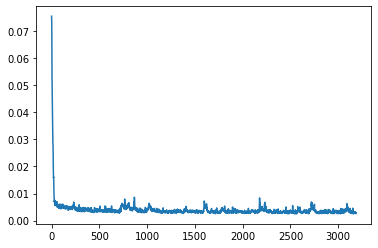

In [212]:
plt.plot(losses)

In [172]:
results

[array([[[0.48630401, 0.49325076, 0.43722266],
         [0.4233407 , 0.44794175, 0.377797  ],
         [0.34722638, 0.43615222, 0.32055768],
         ...,
         [0.31538355, 0.40026876, 0.30433685],
         [0.3569716 , 0.39607736, 0.3093501 ],
         [0.3666349 , 0.38063142, 0.37176526]],
 
        [[0.37346613, 0.38704577, 0.33639592],
         [0.32116443, 0.34716666, 0.24977371],
         [0.24274379, 0.32118875, 0.27487868],
         ...,
         [0.2754936 , 0.33551168, 0.32035956],
         [0.29042178, 0.3161389 , 0.29145285],
         [0.3604032 , 0.31279293, 0.34015843]],
 
        [[0.39176548, 0.3579233 , 0.31358165],
         [0.3530596 , 0.28680912, 0.22231933],
         [0.2872856 , 0.27114716, 0.23977883],
         ...,
         [0.29683167, 0.27528965, 0.27386943],
         [0.3083244 , 0.26629752, 0.2511338 ],
         [0.33908918, 0.2576052 , 0.26753736]],
 
        ...,
 
        [[0.437414  , 0.36015022, 0.38335586],
         [0.4401574 , 0.35939905, 0.34010

In [193]:
fourcc =  cv2.VideoWriter_fourcc(*'mp4v')
videowriter = cv2.VideoWriter(output_path,fourcc, fps, (640,480))
for result in results:
    RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
    videowriter.write(RGB_img)
videowriter.release()

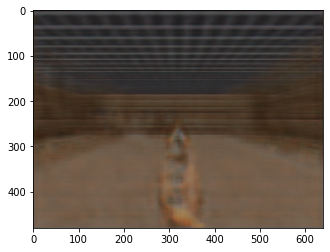

In [192]:
plt.imshow(np.uint8(255*result))

In [183]:

out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), fps, (480,640))
for i in range(len(results)):
    # writing to a image array
    out.write(np.uint8(results[i]))
out.release()

In [70]:
game.close()

In [142]:
autoencoder_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 480, 640, 8)       224       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 240, 320, 8)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 240, 320, 16)      1168      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 120, 160, 32)      4640      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 60, 80, 32)        0  

In [132]:
frame = (screen_buf/255)

In [144]:
encoded_frame = encoder_model.predict(np.expand_dims(frame, 0))
encoded_frame

array([[-0.0639854 , -0.12212464,  0.12227813, -0.1574321 ,  0.15349567,
        -0.08113714, -0.02606815,  0.15255773,  0.07415448, -0.09375374,
        -0.10602891,  0.05207051,  0.12839992, -0.14103197,  0.29119465,
        -0.10072614,  0.12248326,  0.06323166,  0.08846203, -0.04380043,
         0.06410899,  0.05987906,  0.0982798 , -0.09744385, -0.04132511,
        -0.09595089,  0.31295055, -0.02734107,  0.05040722,  0.01034025,
         0.03155817, -0.28869236]], dtype=float32)

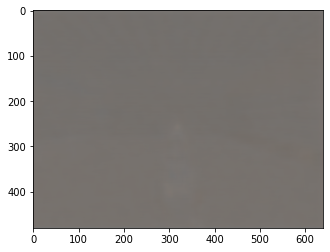

In [165]:
plt.imshow(decoder_model.predict(encoded_frame)[0])

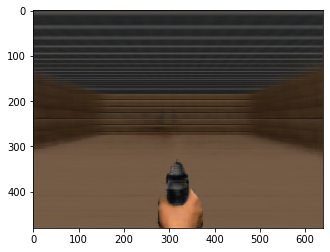

In [251]:
plt.imshow(autoencoder_model.predict(np.expand_dims(screen_buf/255, 0))[0])

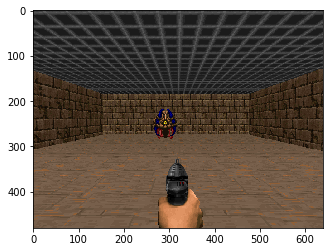

In [250]:
plt.imshow(screen_buf/255)

In [246]:
def get_game_state(state):
    game_object_state = []
    for game_object in state.objects:
        game_object_state = [
            game_object.angle,
    #         game_object.name,
            game_object.pitch,
            game_object.position_x,
            game_object.position_y,
            game_object.position_z,
            game_object.roll,
            game_object.velocity_x,
            game_object.velocity_y,
            game_object.velocity_z,]
        game_object_state+=game_object_state
    return game_object_state

In [247]:
get_game_state(state)

[180.00000004190952,
 0.0,
 0.0,
 60.504974365234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.00000004190952,
 0.0,
 0.0,
 60.504974365234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [236]:
state.objects[0].roll

0.0

In [237]:
game_object_states

[[0.0, 0.0, -384.0, 26.379196166992188, 0.0, 0.0, 0.0, -1.72308349609375, 0.0],
 [180.00000004190952, 0.0, 0.0, 60.504974365234375, 0.0, 0.0, 0.0, 0.0, 0.0]]